<a href="https://colab.research.google.com/github/duartejr/classificador_de_imagens/blob/main/classificador_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo

Considerando o dataset Grapevine Leaves, escolha uma rede pré-treinada para fazer transferência de aprendizado por meio de fine-tuning. Determine quais camadas serão acrescentadas, o tamanho do batch, a quantidade de épocas e a forma de treinamento (fit ou train_on_batch). Compare a predição com a extração de características.

# Preparação do ambiente

## Importação das bibliotecas para leitura das imagens de montagem dos datasets

In [ ]:
import os
import numpy as np
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

## Diretório das imagens

In [ ]:
# Diretório onde estão armazenadas as imagens
images_dir = '/content/drive/MyDrive/Grapevine_Leaves_Image_Dataset'

# Lista de sub diretórios 
sub_dirs = os.listdir(images_dir)

## Rotina de carregamento das imagens


In [ ]:
import os

def load_images(img_dir, folders):
    '''
    Rotina para carregamento das imagens:
    Args:
    img_dir (string) : Diretório onde as imagens estão armazenadas.
    folder (list) : Lista com o nome dos subdiretórios onde as imagens estão armazenadas. 

    Returns:
    X (np.array) : Array com as imagens carregadas
    y (np.array) : Array com a categoria de cada uma das imagens
    '''
    X = []
    y = []

    for folder in folders:
        images = glob(f'{img_dir}/{folder}/*.png')
        for image_file in images:
            image = Image.open(image_file)
            X.append(image)
            y.append(folder)

    return np.array(X), np.array(y)

## Rotina para ajustar as imagens para a resolução de entrada da rede

In [ ]:
def convert_images(images_list):
    '''
    Método para ajustar as imagens para as dimensões de entrada da VGG-19
    Args:
    images_list (np.Array) : Array de imagens a serem convertidas

    Return:
    images_converted (np.Array) : Array com as imagens ajustadas à configuração de entrada da VGG-19.
    '''
    images_converted = []

    for image in images_list:
        image = image.resize((224,224))     # Redimensiona imagem
        image = image.convert('RGB')        # Converte de RGBA para RGB
        image = np.asarray(image)           # Imagem para o formato np.Array
        images_converted.append(image)
    
    return np.array(images_converted)


## Rotina para separar os grupos de treino e teste

In [ ]:
def split_sets(X, y):
    '''
    Método para realizar a separação dos grupos de treino e teste
    '''
    return train_test_split(X, y, test_size=.3, random_state=101, stratify=y, shuffle=True)

## Leitura das imagens

In [ ]:
X, y = load_images(images_dir, sub_dirs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Aplicando Encoder na coluna y 

Ação necessária para que a coluna fique no formato de multilabel.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
ohe = OneHotEncoder(sparse=False)
y_multilabel = ohe.fit_transform(pd.DataFrame(y))
y_multilabel.shape

(500, 5)

Após este processo a variável `y_multilabel`fica com 500 linhas e 5 colunas. A quantidade de linhas refere-se ao total de imagens do dataset. A 5 colunas são referentes a cada uma dos 5 espécies de folhas do dataset.

## Realizando ajuste da resolução das imagens

O ajuste da resolução é feito para que cada imagem fique com a mesma resolução de entrada da Rede.

In [ ]:
X_converted = convert_images(X)

## Divisão dos grupos de treino e teste

In [ ]:
X_train, X_test, y_train, y_test = split_sets(X_converted, y_multilabel)

# Exercícios

## Questão 01
Escolha uma rede pré-treinada em imagens para fazer transferência de aprendizado por meio de fine-tuning:


Como neste trabalho é pedido para comparar o uso do fine-tuning com a extração de características do primeiro projeto utilizarei novamente a rede VGG19. Assim, a comparação entre os resultados será mais justa pois, estarei mantendo a mesma rede e mudando apenas a metodologia para classificação.

Importação de todas as bibliotecas e pacotes necessários

In [ ]:
import os
import numpy as np
from PIL import Image

from keras.datasets import cifar10
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential, load_model
from tensorflow.keras.applications import vgg19

import matplotlib.pyplot as plt

a) Determine quais camadas serão acrescentadas, o tamanho do batch, a quantidade de épocas e a forma de treinamento (fit ou train_on_batch).

Serão acrescentadas duas camadas extras. A primeira é a Flatten e a segunda será uma camada densa. Na camada serão adicionados 5 neurônicos pois, este é o número de classes existentes no dataset.

Vou definir um batch de 64. Realizei testes anteriores e não exibidos com um batch menor e a rede não teve um bom desempenho. Além disso, para batchs maiores o ambiente do Colab chega a acusar uso excessivo de memória RAM.

O modelo será treinado com 100 épocas. Valores maiores poderiam gerar melhores resultados porém, por questões de limitações de tempo e poder computacional tive de me limitar a este número de épocas.



### Função para a definição da rede

In [ ]:
def configure_net(optimizer='adam', neurons_dense=5, show_summary=True):
    """
    Configurações iniciais da rede

    Args:
    optimizer [string]  : Otimizador a ser utilizados
    neuros_dense [int]  : Número de neurônios da camada densa
    show_summary [bool] : Se True exibe o sumário da rede

    Returns:
    model : Modelo da rede
    """
    print("Carregando o modelo da VGG19")
    model = vgg19.VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=True)
    model = Model(inputs=model.input, outputs=model.get_layer(index=-2).output) #-2 mantendo o include_top=True

    print("\tAdicionando novas camadas ao modelo ...")
    newTop = Sequential()
    newTop.add(Flatten(input_shape=model.output_shape[1:]))
    newTop.add(Dense(neurons_dense, activation='softmax')) # 5 é o número de classes

    print("\tConfigrando o fine-tuning...")
    model = Model(inputs=model.input, outputs=newTop(model.output))

    if show_summary:
        model.summary()
    
    # pesquisar learning_rate
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


### Função para o treinamento da rede

In [ ]:
def train_model(model, X_train, y_train, batch_size=64, epochs=50):
    """
    Reliza o treino da rede

    Args: 
    model : A rede a ser treinado
    X_train [array] : Conjunto de imagens para treino
    y_train [array] : Lista com a categoria de cada imagem de treino
    batch_size [int] : Tamanho do batch de treino
    epochs [int] : Número de épocas

    Returns:
    model : Modelo treinado
    acc_loss [list] : Lista com a acurácia de cada época
    err_loss [list] : Lista com o erro de cada época
    """
    print("treinando o modelo ...")
    batches = list(range(0, len(y_train), batch_size))
    perm = np.random.permutation(len(y_train))
    err_loss = []
    acc_loss = []
    err_loss.append(1)
    acc_loss.append(0)

    for e in range(0, epochs):
        for b in batches:
            if b + batch_size < len(y_train):
                x = X_train[perm[b : b + batch_size]]
                y = y_train[perm[b : b + batch_size]]
            else:
                x = X_train[perm[b : ]]
                y = y_train[perm[b : ]]
            
            loss = model.train_on_batch(x, y)

        #print("\tEpoch %i. [Error, Accuracy]: %.15f, %.15f " % (e+1, loss[0], loss[1]))
        err_loss.append(loss[0])
        acc_loss.append(loss[1])
    
    print("\tEpoch %i. [Error, Accuracy]: %.15f, %.15f " % (e+1, loss[0], loss[1]))
    return model, acc_loss, err_loss

## Função para plotar o gráfico de perda e acurácia

In [ ]:
def plot_accvloss(acc_loss, err_loss):
    """
    Plot o gráfico de perda vesus acurácia

    Args:
    acc_loss [list] : Lista de valores de acurácia
    err_loss [list] : Lista de valores de erro
    """
    plt.plot(err_loss, label="Err")
    plt.plot(acc_loss, label="Acc")
    plt.xlim([0, len(err_loss)-1])
    plt.ylim([0, max(err_loss)])
    plt.legend(loc='upper right')
    plt.ylabel('Loss/Accuracy')
    plt.xlabel('Epochs')
    plt.margins(0.5, 0.5)
    plt.show()

## Treinando e testando a rede

Carregando o modelo da VGG19
574726144/574710816 [==============================] - 3s 0us/step
	Adicionando novas camadas ao modelo ...
	Configrando o fine-tuning...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)  

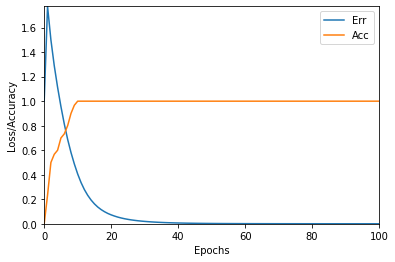

Testing the model ...
3/3 [==============================] - 3s 1s/step - loss: 0.4744 - accuracy: 0.8800
['loss', 'accuracy']
	Top-1 Accuracy: 0.88


In [ ]:
model = configure_net(optimizer='adadelta')

model, acc_loss, err_loss = train_model(model, X_train, y_train, epochs=100)

plot_accvloss(acc_loss, err_loss)

print("Testing the model ...")
acc = model.evaluate(X_test, y_test, batch_size=64)
print(model.metrics_names)
print("\tTop-1 Accuracy: %.2f" % acc[1])

## b) Compare a predição diretamente pela rede com a extração de características.


No projeto feito anteriormente a acurácia máxima obtida foi de 0,54. A acurácia obtida com o processo de fine-tuning passou para 0,8 utilizando a mesma rede do projeto anterior. Portanto, o uso da técnica de fine-tuning mostrou-se mais eficiente para realizar a classificação deste conjunto de imagem. Assim, em uma aplicação prática, seria recomendado fazer uso deste novo modelo para realiza a classificação das imagens de folhas de uvas.

## Questão 2
Considerando a mesma rede pré-treinada do exercício anterior, faça fine-tuning congelando algumas camadas. Determine a quantidade de camadas a serem congeladas, indique o setup escolhido e compare o resultado obtido em relação ao fine-tuning convencional.

A aplicação do congelamento das camadas gerou uma diminuição do desempenho do modelo. Após alguns teste cheguei ao resultado de que congelando apenas 5 camadas os prejuízos ao desempenho do modelo seriam menores.

Carregando o modelo da VGG19
	Adicionando novas camadas ao modelo ...
	Configrando o fine-tuning...
treinando o modelo ...
	Epoch 100. [Error, Accuracy]: 0.000099263823358, 1.000000000000000 


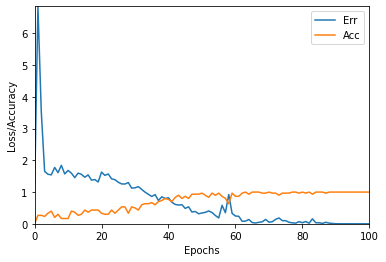

Testing the model ...
3/3 [==============================] - 1s 247ms/step - loss: 5.8484 - accuracy: 0.4133
['loss', 'accuracy']
	Top-1 Accuracy: 0.41


In [ ]:
model = configure_net(optimizer='adam', show_summary=False)

for layer in model.layers[:-int(5)]:
    layer.trainable = False

model, acc_loss, err_loss = train_model(model, X_train, y_train, epochs=100)

plot_accvloss(acc_loss, err_loss)

print("Testing the model ...")
acc = model.evaluate(X_test, y_test, batch_size=64)
print(model.metrics_names)
print("\tTop-1 Accuracy: %.2f" % acc[1])

A aplicação do congelamento não foi boa por dois motivos. Primeiro ela não permitiu utilizar o otimizador adadelta, que apresenta resultados melhores que o Adam, para este caso. O segundo é que como a rede não foi originalmente treinada para este tipo de imagem ela perde a capacidade de se adaptar para o novo conjunto de dados.

## Questão 03
Considerando a mesma rede pré-treinada do primeiro exercício, faça fine-tuning com Data Augmentation. Explore essas técnicas e verifique se sua utilização melhora a performance do modelo. Não fique restrito às técnicas de exemplo. Estude as demais funções existentes no pacote ImageGenerator.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def transform_image(image, method):
    """
    Função que realiza uma transformação aletaória na imagem

    Args:
    image [array]   : Imagem a ser alterada
    method [string] : Método de transformação a ser aplicado

    Returns:
    batch [array]   : Imagem transformada
    """

    random_n = float(np.random.randint(30, 271)) # Valor elatório da itensidade da modificação

    if method == 'rotation_range':
        # rotaciona a imagem de acordo com a quantidade de graus informados
        datagen = ImageDataGenerator(rotation_range=random_n) 
    elif method == 'width_shift_range':
        # Altera a preenchida largura da imagem
        datagen = ImageDataGenerator(width_shift_range=round(random_n / 271, 1))
    elif method == 'height_shift_range':
        # Altera a altura preenchida da imagem
        datagen = ImageDataGenerator(height_shift_range=round(random_n / 271, 1))
    elif method == 'shear_range':
        # Cisalhamento da imagem (ângulo de cisalhamento no sentido anti-horário em graus)
        datagen = ImageDataGenerator(shear_range=random_n)
    elif method == 'zoom_range':
        # Aplica zoom na imagem
        datagen = ImageDataGenerator(zoom_range=round(random_n / 271, 1))
    elif method == 'horizontal_flip':
        # Inverte a imagem horizontalmente
        datagen = ImageDataGenerator(horizontal_flip = True)
    else:
        # Inverte a imagem verticalmente
        datagen = ImageDataGenerator(vertical_flip = True)
    
    # Aplica a transformação na imagem
    it = datagen.flow(np.expand_dims(image, 0), batch_size=1) 
    batch = it.next()

    return batch[0].astype(np.uint8)

In [ ]:
def image_augmentation(X, y, n_samples):
    """
    Realiza o processo de augmentation

    Args:
    X [array] : Conjunto de imagens base
    y [array] : Lista com a categorias das imagens originais
    n_samples [Int] : Número de transformações a ser realizado em cada imagems. O conjunto final será n_samples vezes maior que o conjunto X.

    Returns:
    imagens [array] : Conjunto de imagens transformadas
    labels [arry] : Lista com a categoria de cada nova imagem
    """
    print("\tCriando augmentation usando o Keras ...")
    augmentation_methods = ['rotation_range', 'width_shift_range', 'height_shift_range', 'shear_range',
                            'zoom_range', 'horizontal_flip', 'vertical_flip']

    method = np.random.choice(augmentation_methods)
    images = []
    labels = []

    for _ in range(n_samples):
        for i in range(0, X.shape[0]):
            batch = transform_image(X[i], method)
            images.append(batch)
            labels.append(y[i])
        
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# chamada da função; após, concatenamos os dados gerados aos dados originais
images, labels = image_augmentation(X_train, y_train, 3)
X_train_v2 = np.concatenate((X_train, images), axis=0)
y_train_v2 = np.concatenate((y_train, labels), axis=0)

print('\tTraining set shape: ', X_train_v2.shape)
print('\tTesting set shape: ', X_test.shape)
print('\tTraining label shape: ', y_train_v2.shape)
print('\tTesting label shape: ', y_test.shape)

	Criando augmentation usando o Keras ...
	Training set shape:  (1400, 224, 224, 3)
	Testing set shape:  (150, 224, 224, 3)
	Training label shape:  (1400, 5)
	Testing label shape:  (150, 5)


Treinando e testando a rede com Augmentation

Carregando o modelo da VGG19
	Adicionando novas camadas ao modelo ...
	Configrando o fine-tuning...
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                         

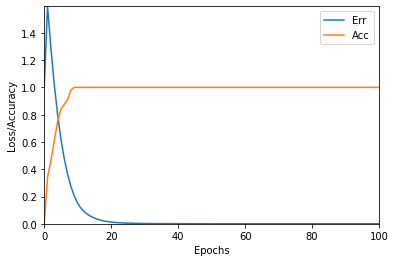

Testando o modelo ...
3/3 [==============================] - 1s 267ms/step - loss: 1.0728 - accuracy: 0.8600
['loss', 'accuracy']
	Top-1 Accuracy: 0.86


In [ ]:
model = configure_net(optimizer='adadelta')

model, acc_loss, err_loss = train_model(model, X_train_v2, y_train_v2, epochs=100)

plot_accvloss(acc_loss, err_loss)

print("Testando o modelo ...")
acc = model.evaluate(X_test, y_test, batch_size=64)
print(model.metrics_names)
print("\tTop-1 Accuracy: %.2f" % acc[1])

## Questão 04
Interpretação dos resultados:

### a) Baseando-se nos experimetnos anteriores, indique a melhor solução para este conjunto de dados.

A melhor escolha, para este caso, é o uso do fine-tuning simples. As outras técnicas mostraram desempenho inferior ao obtido para o processo de augmentation. O uso do método de extração de caracetéristicas obteve uma acurácia máxima de 0,54 apenas enquanto que o fine-tuning simples obteve uma acurácia de 0,88. O congelamento das camadas resultou em um desempnho inferior ao fine-tuning tradicional além de não permitir o uso do otimizador Adadelta que proporcionou um resultado melhor do que o otimizador Adam. O método de Augmentation aparentemente não resultou em uma melhora no resultado do modelo ficando com acurácia média final de 0.86. Talvez se o pode-se ter sido testado o Augmentation com mais modificações nos dados houvesse uma melhora no resulto. Porém, por limitações do ambiente do desenvolvimento não foi possível realizar novos testes. Na rodada final o procedimento de augmentation levou cerca de 30 minutos para fazer o procedimento de treino e teste da rede enquanto os demais levaram menos de 10 minutos.

### b) Apresente gráficos e dados comparativos que justifiquem suas escolhas.

In [ ]:
import pandas as pd


results = pd.DataFrame([[0.54], [0.88], [0.41], [0.86]], 
                       index=['Extração de características',
                              'Fine-tuning',
                              'Congelamento de camadas',
                              'Augmentation'],
                       columns=['Acurácia'])

In [ ]:
results

,Acurácia
Extração de características,0.54
Fine-tuning,0.88
Congelamento de camadas,0.41
Augmentation,0.86


(0.0, 1.0)

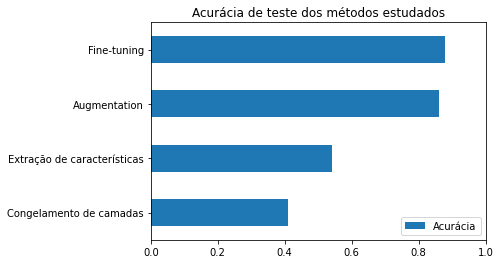

In [ ]:
results.sort_values(by='Acurácia').plot(kind='barh')
plt.title('Acurácia de teste dos métodos estudados')
plt.xlim(0, 1)